In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Subset

from sklearn.model_selection import train_test_split

from torchsummary import summary
from PIL import Image
import torchvision
from torchvision import transforms
from torchvision.io import read_image
from pathlib import Path

import time

import random

import copy

import sklearn.metrics as skm

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
class StrokeDataset(Dataset):
    def __init__(self, root_path, test=False):
        self.root_path = root_path
        if test:
            self.images = sorted([root_path+"/Test/"+i for i in os.listdir(root_path+"/Test/")])
            self.masks = sorted([root_path+"/Test_mask/"+i for i in os.listdir(root_path+"/Test_mask/")])
        else:
            self.images = sorted([root_path+"/Train/"+i for i in os.listdir(root_path+"/Train/")])
            self.masks = sorted([root_path+"/Train_mask/"+i for i in os.listdir(root_path+"/Train_mask/")])

        self.transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor()])

    def __getitem__(self, index):
        img = Image.open(self.images[index]).convert("RGB")
        mask = Image.open(self.masks[index]).convert("L")

        return self.transform(img), self.transform(mask)

    def __len__(self):
        return len(self.images)

In [ ]:
def data_generator(path, target_size=(256, 256), augmentation=False, augmentation_factor=1):

    image_list = []

    base_transform = transforms.Compose([
        transforms.Resize(target_size),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x[:3,:,:])
    ])

    # Veri artırma dönüşümleri
    augmentation_transforms = [
        # Orijinal görüntü için baz dönüşüm
        base_transform,

        # Yatay döndürme
        transforms.Compose([
            transforms.Resize(target_size),
            transforms.RandomHorizontalFlip(p=1.0),
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x[:3,:,:])
        ]),

        # Hafif döndürme
        transforms.Compose([
            transforms.Resize(target_size),
            transforms.RandomRotation(degrees=15),
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x[:3,:,:])
        ]),

        # Parlaklık ve kontrast ayarları
        transforms.Compose([
            transforms.Resize(target_size),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x[:3,:,:])
        ]),

        # Hafif zoom
        transforms.Compose([
            transforms.Resize((int(target_size[0]*1.1), int(target_size[1]*1.1))),
            transforms.CenterCrop(target_size),
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x[:3,:,:])
        ]),

        # Hafif bulanıklaştırma
        transforms.Compose([
            transforms.Resize(target_size),
            transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0)),
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x[:3,:,:])
        ])
    ]

    image_files = sorted(os.listdir(path))

    for image_name in image_files:
        image_path = os.path.join(path, image_name)

        img = Image.open(image_path)

        # Orijinal görüntüyü ekle
        img_tensor = base_transform(img)
        image_list.append(img_tensor)

        # Eğer veri artırma isteniyorsa
        if augmentation:
            # Kaç tane dönüşüm uygulayacağımızı belirle (augmentation_factor kadar)
            num_transforms = min(augmentation_factor, len(augmentation_transforms)-1)

            # Dönüşümleri rastgele seç (ilk dönüşüm orijinal görüntü olduğu için 1'den başla)
            chosen_transforms = random.sample(range(1, len(augmentation_transforms)), num_transforms)

            for transform_idx in chosen_transforms:
                transform = augmentation_transforms[transform_idx]
                augmented_tensor = transform(img)
                image_list.append(augmented_tensor)

    data = torch.stack(image_list)
    return data

In [ ]:
# No stroke images

folder_path = "/content/drive/My Drive/veriler/train_val/inmesiz"

print("Images are loading...")
NS_images = data_generator(folder_path)

print(f"Total images: {NS_images.shape[0]}")
print(f"Shapes: {NS_images[0].shape}")


Images are loading...
Total images: 4427
Shapes: torch.Size([3, 256, 256])


In [ ]:

# Stroke images

folder_path = "/content/drive/My Drive/veriler/train_val/inmeli"

print("Images are loading...")
S_images = data_generator(folder_path, augmentation=True, augmentation_factor=1)

print(f"Total stroke images: {S_images.shape[0]}")
print(f"Stroke images shape: {S_images[0].shape}")

Images are loading...
Total images: 2260
Shapes: torch.Size([3, 256, 256])


In [ ]:
# Test images

folder_path_NS = "/content/drive/My Drive/veriler/test/inmesiz"
folder_path_S = "/content/drive/My Drive/veriler/test/inmeli"

print("Images are loading...")
NS_test_images = data_generator(folder_path_NS)
S_test_images = data_generator(folder_path_S)

print(f"Total no stroke test images: {NS_test_images.shape[0]}")
print(f"No stroke test images shape: {NS_test_images[0].shape}")

print(f"Total stroke test images: {S_test_images.shape[0]}")
print(f"Stroke test images shape: {S_test_images[0].shape}")

Images are loading...
Total images: 2186
Shapes: torch.Size([3, 256, 256])


In [ ]:
# Global değişkenler tanımla
transformed_train_features = None
train_labels = None
transformed_dev_features = None
dev_labels = None


In [ ]:
train_val_data = torch.cat((NS_images, S_images), dim=0)
train_val_labels = torch.cat((torch.zeros(NS_images.shape[0]), torch.ones(S_images.shape[0])), dim=0)

test_data = torch.cat((NS_test_images, S_test_images), dim=0)
test_labels = torch.cat((torch.zeros(NS_test_images.shape[0]), torch.ones(S_test_images.shape[0])), dim=0)
test_labels = test_labels[:,None]

In [ ]:

train_data, dev_data, train_o_data, dev_o_data, train_labels, dev_labels = train_test_split(
    all_data,
    AE_labels,
    labels,
    test_size=0.2
    )

print(f"Train data: {train_data.shape}")
print(f"Dev data: {dev_data.shape}")
print(f"Train Overlay data: {train_o_data.shape}")
print(f"Dev Overlay data: {dev_o_data.shape}")
print(f"Train labels: {train_labels.shape}")
print(f"Dev labels: {dev_labels.shape}")


Train data: torch.Size([7098, 3, 256, 256])
Dev data: torch.Size([1775, 3, 256, 256])
Train Overlay data: torch.Size([7098, 3, 256, 256])
Dev Overlay data: torch.Size([1775, 3, 256, 256])
Train labels: torch.Size([7098, 1])
Dev labels: torch.Size([1775, 1])


In [ ]:
# Split the data into train and dev

train_data, dev_data, train_labels, dev_labels = train_test_split(
    train_val_data,
    train_val_labels,
    test_size=0.2
)

print(f"Train data shape: {train_data.shape}")
print(f"Dev data shape: {dev_data.shape}")
print("--------------------------------")
print(f"Train labels shape: {train_labels.shape}")
print(f"Dev labels shape: {dev_labels.shape}")

In [ ]:
train_dataset = TensorDataset(train_data, train_labels)
dev_dataset = TensorDataset(dev_data, dev_labels)
test_dataset = TensorDataset(test_data, test_labels)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=test_dataset.tensors[0].shape[0])

# U-net dataset


In [ ]:
UNET_DATA_PATH =

train_dataset = StrokeDataset(UNET_DATA_PATH)


train_dataset, val_dataset = random_split(train_dataset, [0.8, 0.2], generator=generator)

train_dataloader = DataLoader(dataset=train_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=True)

In [ ]:
def AE_model():
    class UNet(nn.Module):
        def __init__(self):
            super().__init__()

            # Encoder (Sol taraf)
            # Encoder Blok 1
            self.enc1_conv1 = nn.Conv2d(3, 32, 3, padding=1)
            self.enc1_relu1 = nn.ReLU(inplace=True)
            self.enc1_conv2 = nn.Conv2d(32, 32, 3, padding=1)
            self.enc1_relu2 = nn.ReLU(inplace=True)
            self.enc1_pool = nn.MaxPool2d(2, 2)  # 256x256 -> 128x128

            # Encoder Blok 2
            self.enc2_conv1 = nn.Conv2d(32, 64, 3, padding=1)
            self.enc2_relu1 = nn.ReLU(inplace=True)
            self.enc2_conv2 = nn.Conv2d(64, 64, 3, padding=1)
            self.enc2_relu2 = nn.ReLU(inplace=True)
            self.enc2_pool = nn.MaxPool2d(2, 2)  # 128x128 -> 64x64

            # Encoder Blok 3
            self.enc3_conv1 = nn.Conv2d(64, 128, 3, padding=1)
            self.enc3_relu1 = nn.ReLU(inplace=True)
            self.enc3_conv2 = nn.Conv2d(128, 128, 3, padding=1)
            self.enc3_relu2 = nn.ReLU(inplace=True)
            self.enc3_pool = nn.MaxPool2d(2, 2)  # 64x64 -> 32x32

            # Encoder Blok 4
            self.enc4_conv1 = nn.Conv2d(128, 256, 3, padding=1)
            self.enc4_relu1 = nn.ReLU(inplace=True)
            self.enc4_conv2 = nn.Conv2d(256, 256, 3, padding=1)
            self.enc4_relu2 = nn.ReLU(inplace=True)
            self.enc4_pool = nn.MaxPool2d(2, 2)  # 32x32 -> 16x16

            # Bottleneck (En alt kısım)
            self.bottleneck_conv1 = nn.Conv2d(256, 512, 3, padding=1)
            self.bottleneck_relu1 = nn.ReLU(inplace=True)
            self.bottleneck_conv2 = nn.Conv2d(512, 512, 3, padding=1)
            self.bottleneck_relu2 = nn.ReLU(inplace=True)

            # Decoder (Sağ taraf)
            # Decoder Blok 4
            self.upsample4 = nn.ConvTranspose2d(512, 256, 2, stride=2)  # 16x16 -> 32x32
            self.dec4_conv1 = nn.Conv2d(512, 256, 3, padding=1)  # 256 + 256 (skip) = 512
            self.dec4_relu1 = nn.ReLU(inplace=True)
            self.dec4_conv2 = nn.Conv2d(256, 256, 3, padding=1)
            self.dec4_relu2 = nn.ReLU(inplace=True)

            # Decoder Blok 3
            self.upsample3 = nn.ConvTranspose2d(256, 128, 2, stride=2)  # 32x32 -> 64x64
            self.dec3_conv1 = nn.Conv2d(256, 128, 3, padding=1)  # 128 + 128 (skip) = 256
            self.dec3_relu1 = nn.ReLU(inplace=True)
            self.dec3_conv2 = nn.Conv2d(128, 128, 3, padding=1)
            self.dec3_relu2 = nn.ReLU(inplace=True)

            # Decoder Blok 2
            self.upsample2 = nn.ConvTranspose2d(128, 64, 2, stride=2)  # 64x64 -> 128x128
            self.dec2_conv1 = nn.Conv2d(128, 64, 3, padding=1)  # 64 + 64 (skip) = 128
            self.dec2_relu1 = nn.ReLU(inplace=True)
            self.dec2_conv2 = nn.Conv2d(64, 64, 3, padding=1)
            self.dec2_relu2 = nn.ReLU(inplace=True)

            # Decoder Blok 1
            self.upsample1 = nn.ConvTranspose2d(64, 32, 2, stride=2)  # 128x128 -> 256x256
            self.dec1_conv1 = nn.Conv2d(64, 32, 3, padding=1)  # 32 + 32 (skip) = 64
            self.dec1_relu1 = nn.ReLU(inplace=True)
            self.dec1_conv2 = nn.Conv2d(32, 32, 3, padding=1)
            self.dec1_relu2 = nn.ReLU(inplace=True)

            # Son çıktı katmanı
            self.output = nn.Conv2d(32, 3, 1)

        def forward(self, x):
            # Encoder yolu
            # Blok 1
            enc1 = self.enc1_conv1(x)
            enc1 = self.enc1_relu1(enc1)
            enc1 = self.enc1_conv2(enc1)
            enc1 = self.enc1_relu2(enc1)
            enc1_pool = self.enc1_pool(enc1)

            # Blok 2
            enc2 = self.enc2_conv1(enc1_pool)
            enc2 = self.enc2_relu1(enc2)
            enc2 = self.enc2_conv2(enc2)
            enc2 = self.enc2_relu2(enc2)
            enc2_pool = self.enc2_pool(enc2)

            # Blok 3
            enc3 = self.enc3_conv1(enc2_pool)
            enc3 = self.enc3_relu1(enc3)
            enc3 = self.enc3_conv2(enc3)
            enc3 = self.enc3_relu2(enc3)
            enc3_pool = self.enc3_pool(enc3)

            # Blok 4
            enc4 = self.enc4_conv1(enc3_pool)
            enc4 = self.enc4_relu1(enc4)
            enc4 = self.enc4_conv2(enc4)
            enc4 = self.enc4_relu2(enc4)
            enc4_pool = self.enc4_pool(enc4)

            # Bottleneck
            bottleneck = self.bottleneck_conv1(enc4_pool)
            bottleneck = self.bottleneck_relu1(bottleneck)
            bottleneck = self.bottleneck_conv2(bottleneck)
            bottleneck = self.bottleneck_relu2(bottleneck)

            # Decoder yolu
            # Blok 4
            dec4 = self.upsample4(bottleneck)
            dec4 = torch.cat((dec4, enc4), dim=1)  # Skip connection
            dec4 = self.dec4_conv1(dec4)
            dec4 = self.dec4_relu1(dec4)
            dec4 = self.dec4_conv2(dec4)
            dec4 = self.dec4_relu2(dec4)

            # Blok 3
            dec3 = self.upsample3(dec4)
            dec3 = torch.cat((dec3, enc3), dim=1)  # Skip connection
            dec3 = self.dec3_conv1(dec3)
            dec3 = self.dec3_relu1(dec3)
            dec3 = self.dec3_conv2(dec3)
            dec3 = self.dec3_relu2(dec3)

            # Blok 2
            dec2 = self.upsample2(dec3)
            dec2 = torch.cat((dec2, enc2), dim=1)  # Skip connection
            dec2 = self.dec2_conv1(dec2)
            dec2 = self.dec2_relu1(dec2)
            dec2 = self.dec2_conv2(dec2)
            dec2 = self.dec2_relu2(dec2)

            # Blok 1
            dec1 = self.upsample1(dec2)
            dec1 = torch.cat((dec1, enc1), dim=1)  # Skip connection
            dec1 = self.dec1_conv1(dec1)
            dec1 = self.dec1_relu1(dec1)
            dec1 = self.dec1_conv2(dec1)
            dec1 = self.dec1_relu2(dec1)

            # Son çıktı
            output = self.output(dec1)

            return output

    AEnet = UNet()
    AEoptimizer = torch.optim.Adam(AEnet.parameters(), lr=0.001)
    AElossfun = nn.MSELoss()

    return AEnet, AEoptimizer, AElossfun

In [ ]:

AE_net, AE_optimizer, AE_lossfunc = AE_model()

summary(AE_net, (3, 256, 256), device="cpu")


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             896
              ReLU-2         [-1, 32, 256, 256]               0
            Conv2d-3         [-1, 32, 256, 256]           9,248
              ReLU-4         [-1, 32, 256, 256]               0
         MaxPool2d-5         [-1, 32, 128, 128]               0
            Conv2d-6         [-1, 64, 128, 128]          18,496
              ReLU-7         [-1, 64, 128, 128]               0
            Conv2d-8         [-1, 64, 128, 128]          36,928
              ReLU-9         [-1, 64, 128, 128]               0
        MaxPool2d-10           [-1, 64, 64, 64]               0
           Conv2d-11          [-1, 128, 64, 64]          73,856
             ReLU-12          [-1, 128, 64, 64]               0
           Conv2d-13          [-1, 128, 64, 64]         147,584
             ReLU-14          [-1, 128,

In [ ]:
def medrix_model(printtoggle=False):

    class theNet(nn.Module):
        def __init__(self, printtoggle):
            super().__init__()

            self.print = printtoggle

            ###--------------- Feature Map Layers ---------------###

            # First Convolutional Layer
            self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
            self.bnorm1 = nn.BatchNorm2d(16)
            # output size: (np.floor((256 - 3 + 2*1) / 1) + 1)/2 = 128

            # Second Convolutional Layer
            self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
            self.bnorm2 = nn.BatchNorm2d(32)
            # output size: (np.floor((128 - 3 + 2*1) / 1) + 1)/2 = 64

            # Third Convolutional Layer
            self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
            self.bnorm3 = nn.BatchNorm2d(64)
            # output size: (np.floor((64 - 3 + 2*1) / 1) + 1)/2 = 32

            # Fourth Convolutional Layer
            self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
            self.bnorm4 = nn.BatchNorm2d(128)
            # output size: (np.floor((32 - 3 + 2*1) / 1) + 1)/2 = 16

            # Fifth Convolutional Layer
            self.conv5 = nn.Conv2d(128, 256, 3, padding=1)
            self.bnorm5 = nn.BatchNorm2d(256)
            # output size: (np.floor((16 - 3 + 2*1) / 1) + 1)/2 = 8

            # Sixth Convolutional Layer
            self.conv6 = nn.Conv2d(256, 512, 3, padding=1)
            self.bnorm6 = nn.BatchNorm2d(512)
            # output size: (np.floor((8 - 3 + 2*1) / 1) + 1)/2 = 4

            # Seventh Convolutional Layer
            self.conv7 = nn.Conv2d(512, 1024, 3, padding=1)
            self.bnorm7 = nn.BatchNorm2d(1024)
            # output size: (np.floor((4 - 3 + 2*1) / 1) + 1)/2 = 2

            ###-------------- Linear Desicion Layers --------------###

            self.fc1 = nn.Linear(1024*2*2, 1024)
            self.fc2 = nn.Linear(1024, 512)
            self.fc3 = nn.Linear(512, 256)
            self.fc4 = nn.Linear(256, 128)
            self.fc5 = nn.Linear(128, 64)
            self.fc6 = nn.Linear(64, 32)
            self.fc7 = nn.Linear(32, 16)
            self.fc8 = nn.Linear(16, 1)


        def forward(self, x):

            if self.print: print(f"Input shape: {x.shape}")

            # First Convolutional Layer
            x = F.max_pool2d(self.conv1(x),2)
            x = self.bnorm1(F.relu(x))
            if self.print: print(f"After conv1: {x.shape}")

            # Second Convolutional Layer
            x = F.max_pool2d(self.conv2(x),2)
            x = self.bnorm2(F.relu(x))
            if self.print: print(f"After conv2: {x.shape}")

            # Third Convolutional Layer
            x = F.max_pool2d(self.conv3(x),2)
            x = self.bnorm3(F.relu(x))
            if self.print: print(f"After conv3: {x.shape}")

            # Fourth Convolutional Layer
            x = F.max_pool2d(self.conv4(x),2)
            x = self.bnorm4(F.relu(x))
            if self.print: print(f"After conv4: {x.shape}")

            # Fifth Convolutional Layer
            x = F.max_pool2d(self.conv5(x),2)
            x = self.bnorm5(F.relu(x))
            if self.print: print(f"After conv5: {x.shape}")

            # Sixth Convolutional Layer
            x = F.max_pool2d(self.conv6(x),2)
            x = self.bnorm6(F.relu(x))
            if self.print: print(f"After conv6: {x.shape}")

            # Seventh Convolutional Layer
            x = F.max_pool2d(self.conv7(x),2)
            x = self.bnorm7(F.relu(x))
            if self.print: print(f"After conv7: {x.shape}")

            # Flatten the output
            nUnits = x.shape.numel() / x.shape[0]
            x = x.view(-1, int(nUnits))
            if self.print: print(f"After flatten: {x.shape}")

            # Linear Decision Layers
            x = F.relu(self.fc1(x))

            x = F.relu(self.fc2(x))

            x = F.relu(self.fc3(x))

            x = F.relu(self.fc4(x))

            x = F.relu(self.fc5(x))

            x = F.relu(self.fc6(x))

            x = F.relu(self.fc7(x))

            x = self.fc8(x)

            if self.print: print(f"Output shape: {x.shape}")

            return x

    net = theNet(printtoggle)

    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

    lossfunc = nn.BCEWithLogitsLoss()



    return net, optimizer, lossfunc

In [ ]:

net, optimizer, lossfunc = medrix_model(printtoggle=True)

summary(net, (3, 256, 256), device="cpu")


Input shape: torch.Size([2, 3, 256, 256])
After conv1: torch.Size([2, 16, 128, 128])
After conv2: torch.Size([2, 32, 64, 64])
After conv3: torch.Size([2, 64, 32, 32])
After conv4: torch.Size([2, 128, 16, 16])
After conv5: torch.Size([2, 256, 8, 8])
After conv6: torch.Size([2, 512, 4, 4])
After conv7: torch.Size([2, 1024, 2, 2])
After flatten: torch.Size([2, 4096])
Output shape: torch.Size([2, 1])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 256, 256]             448
       BatchNorm2d-2         [-1, 16, 128, 128]              32
            Conv2d-3         [-1, 32, 128, 128]           4,640
       BatchNorm2d-4           [-1, 32, 64, 64]              64
            Conv2d-5           [-1, 64, 64, 64]          18,496
       BatchNorm2d-6           [-1, 64, 32, 32]             128
            Conv2d-7          [-1, 128, 32, 32]          73,856
       BatchNorm2d-8   

In [ ]:

def func2TrainAEnet():
    global transformed_train_features, train_labels, transformed_dev_features, dev_labels

    AEnet, AEoptimizer, AElossfunc = AE_model()
    AEnet.to(device)

    numepochs = 5
    batch_size = 16

    AEtrainLoss = torch.zeros(numepochs)
    AEdevLoss = torch.zeros(numepochs)

    # Early stopping parameters
    patience = 3
    best_val_loss = float('inf')
    counter = 0
    best_model = None

    for epoch in range(numepochs):
        AEnet.train()
        batch_losses = []

        for X, X_o, y in AE_train_loader:
            X = X.to(device)
            X_o = X_o.to(device)

            reconstructed = AEnet(X)
            loss = AElossfunc(reconstructed, X_o)

            AEoptimizer.zero_grad()
            loss.backward()
            AEoptimizer.step()

            batch_losses.append(loss.item())

        AEtrainLoss[epoch] = np.mean(batch_losses)

        AEnet.eval()
        batch_losses = []

        with torch.no_grad():
            for X, X_o, y in AE_dev_loader:
                X = X.to(device)
                X_o = X_o.to(device)

                reconstructed = AEnet(X)
                loss = AElossfunc(reconstructed, X_o)
                batch_losses.append(loss.item())

        current_val_loss = np.mean(batch_losses)
        AEdevLoss[epoch] = current_val_loss

        # Early stopping control
        if current_val_loss < best_val_loss:
            best_val_loss = current_val_loss
            counter = 0
            best_model = copy.deepcopy(AEnet.state_dict())
            print(f"Epoch {epoch+1}: New best validation loss: {current_val_loss:.6f}")
        else:
            counter += 1
            print(f"Epoch {epoch+1}: Validation loss: {current_val_loss:.6f}, Early stopping counter: {counter}/{patience}")

            if counter >= patience:
                print(f"Early stopping! Epoch: {epoch+1}")
                AEnet.load_state_dict(best_model)
                break

    # Load the best model
    if best_model is not None:
        AEnet.load_state_dict(best_model)

    AEnet.eval()

    # Collect transformed features and labels in original order
    # (important: for all examples, without sorting)
    unsorted_train_features = [None] * len(AE_train_ds)
    unsorted_train_labels = [None] * len(AE_train_ds)

    print("Transforming training data...")
    with torch.no_grad():
        # Process each example
        for idx in range(len(AE_train_ds)):
            sample = AE_train_ds[idx]
            X, _, y = sample

            X = X.unsqueeze(0).to(device)
            feature = AEnet(X).cpu().squeeze(0)

            # Save in original order
            unsorted_train_features[idx] = feature
            unsorted_train_labels[idx] = y

    # Do the same for validation
    unsorted_dev_features = [None] * len(AE_dev_ds)
    unsorted_dev_labels = [None] * len(AE_dev_ds)

    print("Transforming validation data...")
    with torch.no_grad():
        for idx in range(len(AE_dev_ds)):
            sample = AE_dev_ds[idx]
            X, _, y = sample

            X = X.unsqueeze(0).to(device)
            feature = AEnet(X).cpu().squeeze(0)

            unsorted_dev_features[idx] = feature
            unsorted_dev_labels[idx] = y

    # Convert lists to tensors
    transformed_train_features = torch.stack(unsorted_train_features)
    train_labels = torch.stack(unsorted_train_labels)
    transformed_dev_features = torch.stack(unsorted_dev_features)
    dev_labels = torch.stack(unsorted_dev_labels)

    print(f"Transformed training data shape: {transformed_train_features.shape}")
    print(f"Training labels shape: {train_labels.shape}")
    print(f"Transformed validation data shape: {transformed_dev_features.shape}")
    print(f"Validation labels shape: {dev_labels.shape}")

    # Create original sorted datasets
    train_dataset = TensorDataset(transformed_train_features, train_labels)
    dev_dataset = TensorDataset(transformed_dev_features, dev_labels)

    # Create new dataloaders - use same samplers
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        sampler=train_sampler
    )

    dev_loader = DataLoader(
        dev_dataset,
        batch_size=batch_size,
        sampler=dev_sampler
    )

    return AEnet, train_loader, dev_loader, AEtrainLoss[:epoch+1], AEdevLoss[:epoch+1]

In [ ]:
def func2TrainMedrixNet(train_loader, dev_loader, printtoggle=True):
    timerInFunction = time.process_time()

    # Hyperparameters
    numepochs = 30
    patience = 5

    # Early stopping parameters
    best_val_acc = 0.0
    counter = 0
    best_model = None

    net, optimizer, lossfunc = medrix_model()
    net.to(device)

    trainAcc = torch.zeros(numepochs)
    trainLoss = torch.zeros(numepochs)
    devAcc = torch.zeros(numepochs)
    devLoss = torch.zeros(numepochs)

    for epoch in range(numepochs):
        net.train()
        batchAcc = []
        batchLoss = []

        for X, y in train_loader:
            X = X.to(device)
            y = y.to(device)

            yHat = net(X)
            loss = lossfunc(yHat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchLoss.append(loss.item())
            batchAcc.append(torch.mean(((yHat>0) == y).float()).item())

        trainLoss[epoch] = np.mean(batchLoss)
        trainAcc[epoch] = 100*np.mean(batchAcc)

        net.eval()
        batchAcc = []
        batchLoss = []

        with torch.no_grad():
            for X, y in dev_loader:
                X = X.to(device)
                y = y.to(device)

                yHat = net(X)
                loss = lossfunc(yHat, y)

                batchLoss.append(loss.item())
                batchAcc.append(torch.mean(((yHat>0) == y).float()).item())

        current_val_loss = np.mean(batchLoss)
        current_val_acc = 100*np.mean(batchAcc)
        devLoss[epoch] = current_val_loss
        devAcc[epoch] = current_val_acc

        comptime = time.process_time() - timerInFunction

        if printtoggle:
            print(f'Epoch {epoch+1}/{numepochs} | '
                  f'Computing time: {comptime:.0f} sec | '
                  f'Train Accuracy: {trainAcc[epoch]:.2f}% | '
                  f'Validation Accuracy: {devAcc[epoch]:.2f}%')

        # Early stopping control
        if current_val_acc > best_val_acc:
            best_val_acc = current_val_acc
            counter = 0
            best_model = copy.deepcopy(net.state_dict())

            if printtoggle:
                print(f"The validation accuracy saved! The best validation accuracy is: {best_val_acc:.2f}%")
                print("")
        else:
            counter += 1
            if printtoggle:
                print(f"Early stopping counter: {counter}/{patience}")
                print("")

            if counter >= patience:
                if printtoggle:
                    print(f"Early stopping! With epoch {epoch+1} training stopped.")
                net.load_state_dict(best_model)
                break

    # Load the best model
    if best_model is not None and epoch == numepochs - 1:
        net.load_state_dict(best_model)
        if printtoggle:
            print("Training finished, the best model is loaded.")

    return trainAcc[:epoch+1], trainLoss[:epoch+1], devAcc[:epoch+1], devLoss[:epoch+1], net


In [ ]:

def test_model(AEnet, CNNnet):
    # Set models to evaluation mode
    AEnet.eval()
    CNNnet.eval()

    # Get the full test data
    test_data, test_labels = test_ds.tensors

    # Pass test data through autoencoder
    with torch.no_grad():
        test_data = test_data.to(device)
        transformed_test_features = AEnet(test_data).cpu()

    # Create test dataloader
    test_dataset = TensorDataset(transformed_test_features, test_labels)
    batch_size = 32
    test_loader_2 = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Make test predictions
    test_predictions = []
    all_labels = []

    with torch.no_grad():
        for X, y in test_loader_2:
            X = X.to(device)
            yHat = CNNnet(X)
            test_predictions.append(yHat)
            all_labels.append(y)

    # Combine predictions and labels
    test_predictions = torch.cat(test_predictions).cpu()
    all_labels = torch.cat(all_labels).cpu()

    # Calculate metrics
    test_acc = skm.accuracy_score(all_labels, (test_predictions > 0))
    test_precision = skm.precision_score(all_labels, (test_predictions > 0))
    test_recall = skm.recall_score(all_labels, (test_predictions > 0))
    test_f1 = skm.f1_score(all_labels, (test_predictions > 0))

    # Confusion matrix
    test_conf = skm.confusion_matrix(all_labels, (test_predictions > 0))

    # Print results
    print("\nTest Results:")
    print(f"Accuracy: {test_acc:.4f}")
    print(f"Precision: {test_precision:.4f}")
    print(f"Recall: {test_recall:.4f}")
    print(f"F1-Score: {test_f1:.4f}")

    print("\nConfusion Matrix:")
    print(test_conf)

    return test_acc, test_precision, test_recall, test_f1, test_conf

In [ ]:

# Görselleştirme fonksiyonu
def visualize_sample(idx):
    # Orijinal görüntüleri al
    original_sample = AE_train_ds[idx]
    x = original_sample[0]  # Orijinal görüntü
    y = original_sample[1]  # Overlay görüntü
    z = original_sample[2]  # Etiket

    # Dönüştürülmüş veriyi al
    a = transformed_train_features[idx]  # Dönüştürülmüş görüntü
    b = train_labels[idx]  # Etiket

    # Görselleştirme
    ae_predic = a.permute(1, 2, 0)
    overlay_train = y.permute(1, 2, 0)
    real_train = x.permute(1, 2, 0)

    fig, ax = plt.subplots(1, 3, figsize=(10, 5))

    ax[0].imshow(ae_predic)
    ax[0].axis('off')
    ax[0].set_title("AE Prediction")

    ax[1].imshow(overlay_train)
    ax[1].axis('off')
    ax[1].set_title("Overlay image")

    ax[2].imshow(real_train)
    ax[2].axis('off')
    ax[2].set_title("Real image")

    print(f"AE label: {z}")
    print(f"CNN label: {b}")

    plt.show()


In [ ]:
# Train autoencoder and get dataloaders for CNN
AEnet, train_loader, dev_loader, AEtrainLoss, AEdevLoss = func2TrainAEnet()


Epoch 1: New best validation loss: 0.000580
Epoch 2: New best validation loss: 0.000516
Epoch 3: Validation loss: 0.002895, Early stopping counter: 1/3
Epoch 4: Validation loss: 0.000691, Early stopping counter: 2/3
Epoch 5: Validation loss: 0.000631, Early stopping counter: 3/3
Early stopping! Epoch: 5
Transforming training data...
Transforming validation data...
Transformed training data shape: torch.Size([7098, 3, 256, 256])
Training labels shape: torch.Size([7098, 1])
Transformed validation data shape: torch.Size([1775, 3, 256, 256])
Validation labels shape: torch.Size([1775, 1])


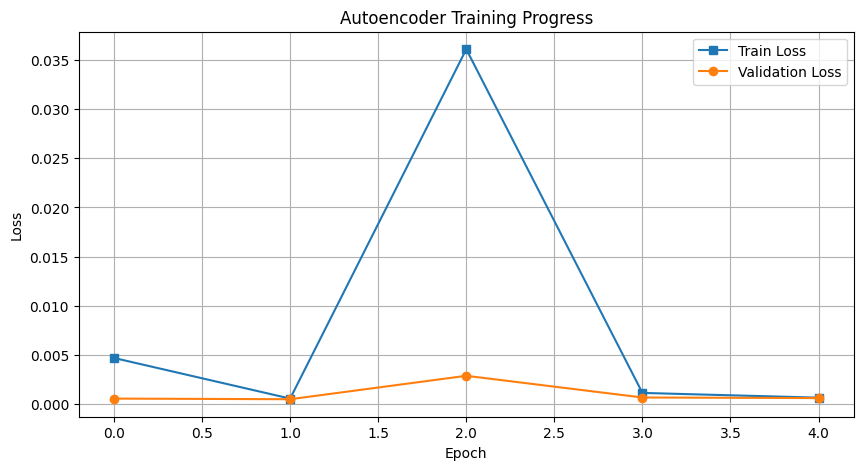

In [ ]:

# Visualize autoencoder training results
plt.figure(figsize=(10,5))
plt.plot(AEtrainLoss,"s-", label='Train Loss')
plt.plot(AEdevLoss,"o-", label='Validation Loss')
plt.title('Autoencoder Training Progress')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


Visualized sample index: 1270


AE label: tensor([1.])
CNN label: tensor([1.])


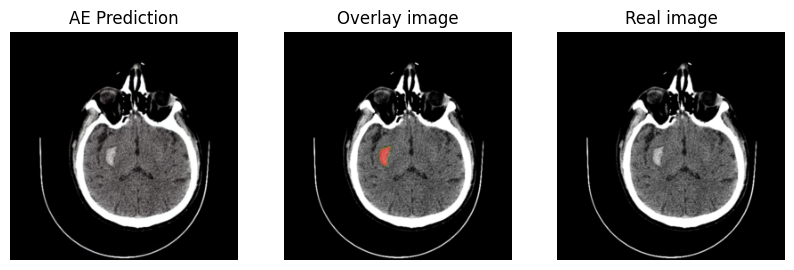

In [ ]:

# Visualize a random sample
random_idx = random.randint(0, len(AE_train_ds) - 1)
print(f"Visualized sample index: {random_idx}")
visualize_sample(random_idx)


In [ ]:
# Train CNN model
trainAcc, trainLoss, devAcc, devLoss, net = func2TrainMedrixNet(train_loader, dev_loader)


Epoch 1/30 | Computing time: 22 sec | Train Accuracy: 65.32% | Validation Accuracy: 74.20%
The validation accuracy saved! The best validation accuracy is: 74.20%

Epoch 2/30 | Computing time: 43 sec | Train Accuracy: 75.26% | Validation Accuracy: 76.74%
The validation accuracy saved! The best validation accuracy is: 76.74%

Epoch 3/30 | Computing time: 65 sec | Train Accuracy: 81.46% | Validation Accuracy: 84.62%
The validation accuracy saved! The best validation accuracy is: 84.62%

Epoch 4/30 | Computing time: 86 sec | Train Accuracy: 86.16% | Validation Accuracy: 84.50%
Early stopping counter: 1/5

Epoch 5/30 | Computing time: 108 sec | Train Accuracy: 89.43% | Validation Accuracy: 90.20%
The validation accuracy saved! The best validation accuracy is: 90.20%

Epoch 6/30 | Computing time: 129 sec | Train Accuracy: 90.14% | Validation Accuracy: 90.02%
Early stopping counter: 1/5

Epoch 7/30 | Computing time: 150 sec | Train Accuracy: 92.72% | Validation Accuracy: 88.80%
Early stopping

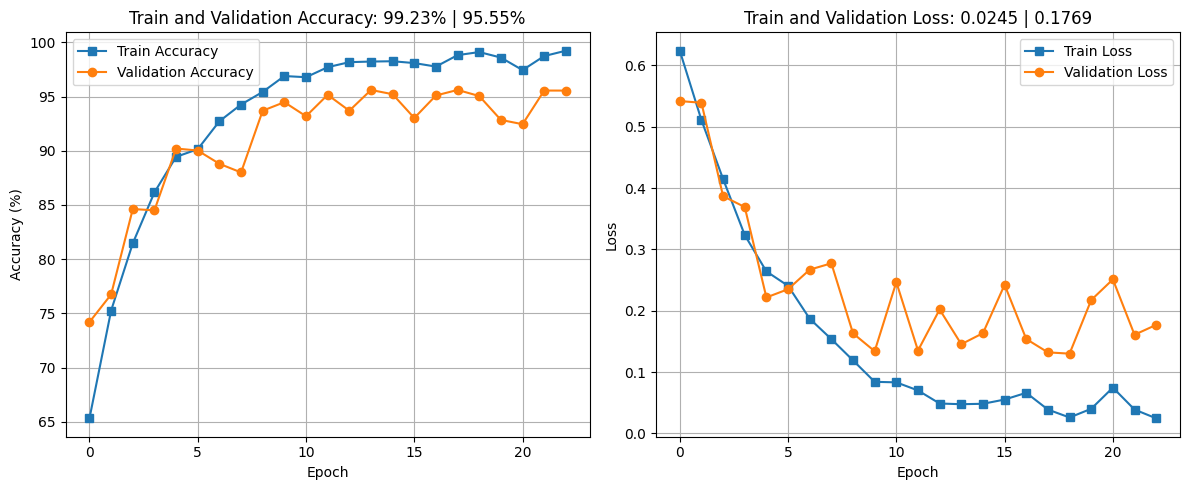

In [ ]:
# Visualize CNN training results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(trainAcc, 's-', label='Train Accuracy')
plt.plot(devAcc, 'o-', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title(f'Train and Validation Accuracy: {trainAcc[-1]:.2f}% | {devAcc[-1]:.2f}%')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(trainLoss, 's-', label='Train Loss')
plt.plot(devLoss, 'o-', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'Train and Validation Loss: {trainLoss[-1]:.4f} | {devLoss[-1]:.4f}')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:

test_acc, test_precision, test_recall, test_f1, test_conf = test_model(AEnet, net)



Test Results:
Accuracy: 0.9050
Precision: 0.8592
Recall: 0.8714
F1-Score: 0.8652

Confusion Matrix:
[[120  10]
 [  9  61]]


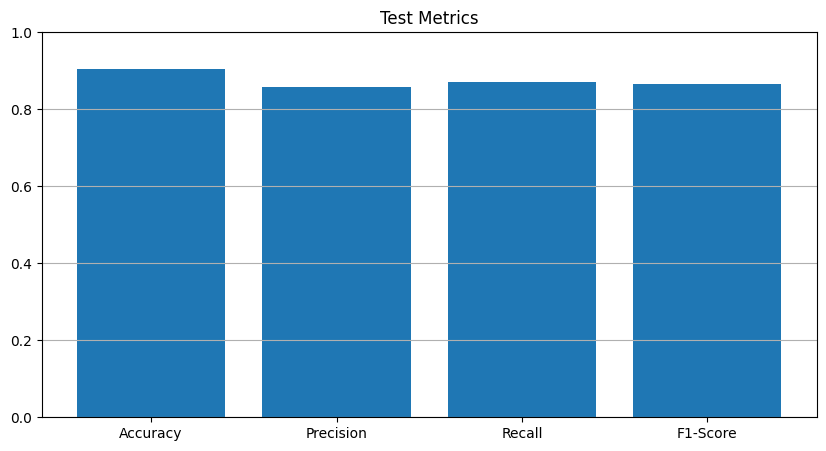

In [ ]:

# Visualize test results
plt.figure(figsize=(10, 5))
plt.bar(['Accuracy', 'Precision', 'Recall', 'F1-Score'],
        [test_acc, test_precision, test_recall, test_f1])
plt.ylim(0, 1)
plt.title('Test Metrics')
plt.grid(True, axis='y')
plt.show()
